In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Lipinski
from rdkit.Geometry import Point3D


import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import HTML

import numpy as np

import mordred
from mordred import Calculator, descriptors


import xgboost
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler



from sklearn.model_selection import train_test_split

In [2]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

In [3]:
#pd.set_option('display.max_rows', 500)

In [4]:
file = '../data/qspr-dataset-02.sdf'

frame = PandasTools.LoadSDF(file,
                            smilesName='SMILES',
                            molColName='Molecule',
                            includeFingerprints=True) \
                            .reset_index() \
                            .set_index("ID") \
                            .drop(columns=["index"])
#frame

RDKit WARNING: [20:02:22] Warning: molecule is tagged as 3D, but all Z coords are zero


In [5]:
suppl = Chem.SDMolSupplier(file)
mol_list = []
for mol in suppl:
    mol_list.append(mol)

RDKit WARNING: [20:02:22] Warning: molecule is tagged as 3D, but all Z coords are zero


In [6]:
#img = Draw.MolsToGridImage(mol_list, molsPerRow=4, maxMols=400)
#img

In [7]:
print(frame.dtypes)
frame = frame.astype({"pLC50": float})

pLC50       object
SMILES      object
Molecule    object
dtype: object


(array([-2.,  0.,  2.,  4.,  6.,  8., 10.]),
 <a list of 7 Text major ticklabel objects>)

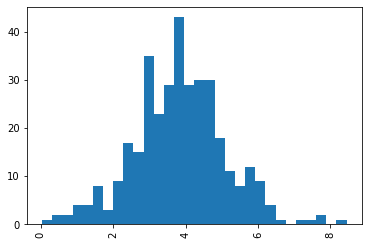

In [8]:
ax = plt.hist(frame["pLC50"].to_list(), bins = 30)
plt.xticks(rotation=90)

In [9]:
frame.describe()

,pLC50
count,352.000000
mean,3.842466
std,1.289585
min,0.037000
25%,3.020750
50%,3.832500
75%,4.657750
max,8.447000


# Clean up molecules

In [10]:
def clean(x):
    #clean up molecule
    x = Chem.AddHs(x)
    AllChem.EmbedMolecule(x, randomSeed=0xf00d)
    return x

In [11]:
frame["Molecule_processed"] = frame["Molecule"].apply(lambda x: clean(x))


In [12]:
HTML(frame.head().to_html())
rdkit.Chem.PandasTools.WriteSDF(frame, out="preprocessed_data.sdf", molColName="Molecule_processed")

# Add Descriptors (Features)

In [22]:
#what could influence toxicity?
frame["heavy_atom_count"] = frame["Molecule"].apply(lambda x: Lipinski.HeavyAtomCount(x))
frame["h_acceptors"] = frame["Molecule"].apply(lambda x: Lipinski.NumHAcceptors(x))
frame["h_donors"] = frame["Molecule"].apply(lambda x: Lipinski.NumHDonors(x))
frame["rotatable_bond_count"] = frame["Molecule"].apply(lambda x: Lipinski.NumRotatableBonds(x))
frame["aromatic_ring_count"] = frame["Molecule"].apply(lambda x: Lipinski.NumAromaticRings(x))


calc_2D = Calculator(descriptors, ignore_3D=True)
#calc_3D = Calculator(descriptors, ignore_3D=False)
mordred_desc_frame = calc_2D.pandas(frame["Molecule"])
print(mordred_desc_frame)
mordred_desc_frame = mordred_desc_frame.astype('float64')

#df

"""calc = mordred.Calculator()
calc.register(mordred.AtomCount.AtomCount("HeavyAtom"))
calc.register(mordred.Aromatic.AromaticAtomsCount)
calc.register(mordred.RotatableBond.RotatableBondsCount)
calc.register(mordred.BondCount.BondCount("any", False))
calc.register(mordred.Aromatic.AromaticBondsCount)
calc.register(mordred.Polarizability.APol)
calc.register(mordred.Polarizability.BPol)
calc.register(mordred.SLogP)
calc.register(mordred.WienerIndex.WienerIndex(True))


descriptors=[]
for desc in calc.descriptors:
    descriptors.append(str(desc))
    
print(descriptors)

frame["mordred"] = frame["Molecule"].apply(lambda x: calc(x))
frame[descriptors] = pd.DataFrame(frame.mordred.tolist(), index= frame.index)
frame.drop(columns = ["mordred"], inplace = True)
print(frame)"""

  4%|▍         | 15/352 [00:01<00:25, 13.19it/s]

/home/caro/anaconda3/envs/qspr_comp/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 352/352 [00:21<00:00, 16.05it/s]


              ABC      ABCGG  nAcid  nBase    SpAbs_A   SpMax_A  SpDiam_A  \
ID                                                                          
Row0     3.535534   3.535534      0      0   6.472136       2.0  3.618034   
Row1     7.071068   6.765664      0      0  13.191508  1.931852  3.863703   
Row2     2.449490   2.449490      0      0   3.464102  1.732051  3.464102   
Row3     9.618017   9.150803      0      0  15.158804  2.337747  4.675495   
Row4    12.302055  12.243011      0      0  20.087778  2.521162  5.042325   
...           ...        ...    ...    ...        ...       ...       ...   
Row347   6.651690   6.355891      0      0   10.79228  2.245827  4.491654   
Row348   5.944584   6.068455      0      0   9.191688  2.278414  4.278414   
Row349   7.358797   6.989468      0      0  11.908678  2.242838  4.485676   
Row350   9.577577   9.256321      0      0  15.169974  2.358294  4.716589   
Row351  12.906262  10.794116      0      0  21.764425  2.315808  4.631617   

'calc = mordred.Calculator()\ncalc.register(mordred.AtomCount.AtomCount("HeavyAtom"))\ncalc.register(mordred.Aromatic.AromaticAtomsCount)\ncalc.register(mordred.RotatableBond.RotatableBondsCount)\ncalc.register(mordred.BondCount.BondCount("any", False))\ncalc.register(mordred.Aromatic.AromaticBondsCount)\ncalc.register(mordred.Polarizability.APol)\ncalc.register(mordred.Polarizability.BPol)\ncalc.register(mordred.SLogP)\ncalc.register(mordred.WienerIndex.WienerIndex(True))\n\n\ndescriptors=[]\nfor desc in calc.descriptors:\n    descriptors.append(str(desc))\n    \nprint(descriptors)\n\nframe["mordred"] = frame["Molecule"].apply(lambda x: calc(x))\nframe[descriptors] = pd.DataFrame(frame.mordred.tolist(), index= frame.index)\nframe.drop(columns = ["mordred"], inplace = True)\nprint(frame)'

,pLC50,SMILES,Molecule,Molecule_processed,heavy_atom_count,h_acceptors,h_donors,rotatable_bond_count,aromatic_ring_count
ID,,,,,,,,,
Row0,2.504,c1cc[nH]c1,,,5,0,1,0,1
Row1,4.818,CCCCCCCCCCO,,,11,1,1,8,0
Row2,0.842,CC(C)O,,,4,1,1,0,0
Row3,4.228,O=[N+]([O-])c1ccc(O)c([N+](=O)[O-])c1,,,13,5,1,2,1
Row4,3.700,CCCC(C)C1(CC)C(=O)NC(=O)N([Na])C1=O,,,17,3,1,4,0

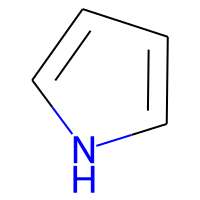
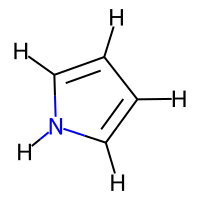
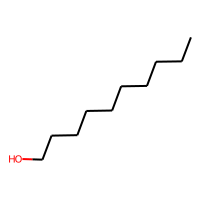
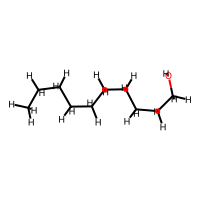
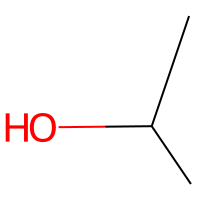
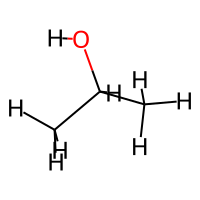
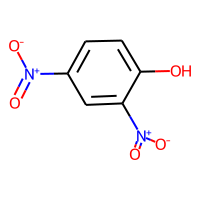
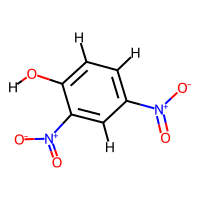
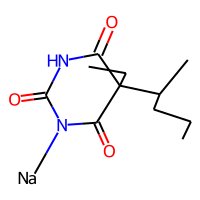
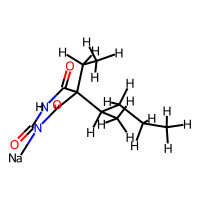

In [19]:
HTML(frame.head().to_html())


# Lasso ? Feature selection

# Split Train / Test / Validation (CV)

In [20]:
y = frame[["pLC50"]].values
X = mordred_desc_frame #frame.drop(columns = ["pLC50", "SMILES", "Molecule", "Molecule_processed"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(246, 1613)
(106, 1613)
(246, 1)
(106, 1)


In [16]:
scores = cross_validation

NameError: name 'cross_validation' is not defined

# Model training

In [21]:
#scaler
stds = StandardScaler()
stds.fit(X_train)

#XGBoost
xgboost_model = xgboost.XGBRegressor(n_estimators=100)
xgboost_model.fit(X_train, y_train)

#Random Forest
rf_model = RandomForestRegressor(random_state=0, n_estimators=100)
rf_model.fit(X_train, y_train.ravel())

#SVM oder so kp bin kein Experte (Caro :) )
svm_model = SVR()
svm_model.fit(stds.transform(X_train), y_train.ravel())

#KNN
knn_model = KNeighborsRegressor()
knn_model.fit(stds.transform(X_train), y_train)


/home/caro/anaconda3/envs/qspr_comp/lib/python3.8/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/caro/anaconda3/envs/qspr_comp/lib/python3.8/site-packages/sklearn/utils/extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
pred_xgb_test = xgboost_model.predict(X_test)
pred_xgb_train = xgboost_model.predict(X_train)

pred_rf_test = rf_model.predict(X_test)
pred_rf_train = rf_model.predict(X_train)

pred_svm_test = svm_model.predict(stds.transform(X_test))
pred_svm_train = svm_model.predict(stds.transform(X_train))

pred_knn_test = knn_model.predict(stds.transform(X_test))
pred_knn_train = knn_model.predict(stds.transform(X_train))

In [ ]:
def get_errors(y_true,y_pred,model_name="Model"):

    err_mae=mae(y_true,y_pred).round(4)
    err_rmse=np.sqrt(mse(y_true,y_pred)).round(4)
    err_r2=r2(y_true,y_pred).round(4)

    print(model_name+" MAE:"+str(err_mae)+" RMSE:"+str(err_rmse)+" R2:"+str(err_r2))
    
    return err_mae,err_rmse,err_r2

In [ ]:
print("\nperformance on testing set:")
get_errors(y_test, pred_rf_test, "Random Forest")
get_errors(y_test, pred_xgb_test, "XGBoost")
get_errors(y_test, pred_svm_test, "SVM")
get_errors(y_test, pred_knn_test, "KNN")

print("\nperformance on training set:")
get_errors(y_train, pred_rf_train, "Random Forest")
get_errors(y_train, pred_xgb_train, "XGBoost")
get_errors(y_train, pred_svm_train, "SVM")
get_errors(y_train, pred_knn_train, "KNN")

